In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from glob import glob
import os
import pickle

import scipy.linalg
import matplotlib.pyplot as plt
import scipy.optimize
import numpy as np

import emcee

import kepler
import threebody

import minuit_wrap
%matplotlib inline

In [3]:
import logging
logger = logging.getLogger()

#logger.setLevel(logging.DEBUG)
fh = logging.FileHandler("fitting.log")
formatter = logging.Formatter('%(asctime)s - %(module)s:%(funcName)s:%(lineno)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)


In [4]:
# numpy binds itself to one CPU; unbind it
#import os
#os.system("taskset -p 0xff %d" % os.getpid());

In [5]:
#import matplotlib
#matplotlib.rcParams['savefig.dpi'] = 120

In [240]:
if False:
    fitter_params = dict(files="tuned2_aligned_pulses_1400_nosun",
                     tzrmjd_middle='auto',
                     parfile="0337_de430.par",
                     fit_pos=True,
                     fit_pm=True,
                     fit_px=True,
                     efac=1,
                     t2_astrometry=True,
                     kopeikin=False,
                     ppn_mode='GR',
                     linear_jumps=True,
                     linear_dm=True,
                     fdn_range=(1,5),
                     priors=('dbeta','dgamma'),
                     toa_mode="pipeline",
                     dmx_span=180,
                     variable_ipm=True)
elif False:
    fitter_params = dict(files="tuned2_aligned_pulses_selected",
                     tzrmjd_middle='auto',
                     parfile="0337_de430.par",
                     fit_pos=True,
                     fit_pm=True,
                     fit_px=True,
                     efac=1,
                     t2_astrometry=True,
                     kopeikin=False,
                     ppn_mode='heavysimple',
                     linear_jumps=True,
                     linear_dm=False,
                     fdn_range=(1,5),
                     priors=('dbeta','dgamma'),
                     toa_mode="pipeline",
                     dmx_span=365.2425/2,
                     variable_dm=True,
                     variable_ipm=True)
elif True:
    fitter_params = dict(files="tuned2_aligned_pulses_1400_nosun2",
                     tzrmjd_middle='auto',
                     parfile="0337_de430.par",
                     fit_pos=True,
                     fit_pm=True,
                     fit_px=True,
                     efac=1,
                     t2_astrometry=True,
                     kopeikin=False,
                     ppn_mode='heavysimple',
                     linear_jumps=True,
                     linear_dm=True,
                     fdn_range=(1,5),
                     priors=('dbeta','dgamma'),
                     toa_mode="pipeline")
with open("fitter_params.pickle","wb") as f:
    pickle.dump(fitter_params,f)
F = threebody.Fitter(**fitter_params)

In [219]:
F.tel_list, len(F.mjds)

(['AO_1400', 'GBT_1400', 'WSRT_1400'], 25153)

In [208]:
print F.parameters
print len(F.parameters)

['asini_i', 'pb_i', 'eps1_i', 'eps2_i', 'tasc_i', 'acosi_i', 'q_i', 'asini_o', 'pb_o', 'eps1_o', 'eps2_o', 'tasc_o', 'acosi_o', 'delta_lan', 'delta', 'dgamma', 'dbeta']
17


In [209]:
F.best_parameters

{'acosi_i': 1.4894313446642388094,
 'acosi_o': 91.359488409202203242,
 'asini_i': 1.2175254087674899358,
 'asini_o': 74.672637105807461035,
 'dbeta': -7.7817805746643927549e-07,
 'delta': -1.0025075497796998863e-06,
 'delta_lan': -1.6872412202101109603e-06,
 'dgamma': 1.8953190051003183278e-06,
 'eps1_i': 0.00068814907307666981902,
 'eps1_o': 0.035185989849887979885,
 'eps2_i': -9.1385666547402762053e-05,
 'eps2_o': -0.0034629936513881790414,
 'pb_i': 1.6293936894564110021,
 'pb_o': 327.2569364441311382,
 'q_i': 0.13742707038658425035,
 'tasc_i': 0.40771664656770575624,
 'tasc_o': 313.93521172856002832}

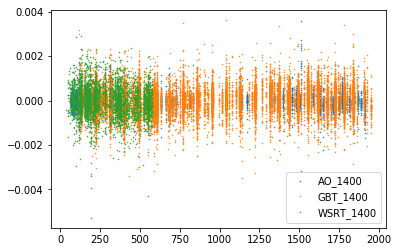

In [210]:
rload = F.residuals(F.best_parameters)
for ti, t in enumerate(F.tel_list):
    c = F.tels == ti
    plt.plot(F.mjds[c], rload[c], 
             ".", markersize=1, label=t)
plt.legend(loc="best")
plt.show()

In [211]:
F.goodness_of_fit(F.best_parameters)

39170.435857570302058

In [212]:
mfun = F.make_mfun()

In [213]:
mfun(*[F.best_parameters[p] for p in F.parameters])

39170.435857570302058

In [214]:
M = minuit_wrap.Fitter(F.make_mfun())

In [215]:
for p in F.parameters:
    M.values[p] = F.best_parameters[p]
    M.errors[p] = F.best_errors[p]
M.set_normalization()

## MINUIT

In [ ]:
M.best_filename = "fitter_best_values.pickle"
M.tol = 100
#M.eps = 1e-6
M.strategy = 1
M.printMode = 3
M.migrad()

## Python optimizer instead

In [ ]:
M.best_filename = "fitter_best_values.pickle"
M.printMode = 3
M.scipy_minimize("Powell", options=dict(ftol=1e-8))

KeyboardInterrupt: 

## NLopt optimizer



In [216]:
M.best_filename = "fitter_best_values.pickle"
M.printMode = 3
M.nlopt_minimize()

## Attic

In [ ]:
M.tol = 100
#M.eps = 1e-6
M.strategy = 1
M.printMode = 3
M.simplex()

In [ ]:
for (i,p) in enumerate(F.parameters):
    M.values[p] = M.best_values[p]
    M.errors[p] = F.best_errors[p]
M.set_normalization() 

In [ ]:
best_so_far = np.load("emcee-chains/1045.nimrod/best_so_far.npy")
for (i,p) in enumerate(F.parameters):
    M.values[p] = best_so_far[i]
    M.errors[p] = F.best_errors[p]
M.set_normalization()    

In [ ]:
M.tol = 100
M.eps = 1e-6
M.strategy = 1
M.printMode = 3
M.migrad()

In [ ]:
for p in F.parameters:
    print p, (M.best_values[p]-F.best_parameters[p])/F.best_errors[p]

In [ ]:
M.best_values

In [ ]:
mfun(*[M.best_values[p] for p in F.parameters])

In [ ]:
if False:
    import cPickle as pickle
    with open(M.best_filename,"wb") as f:
        pickle.dump(M.best_values, f)

In [ ]:
M._minuit.errors

In [ ]:
new_walkers = np.load("emcee-chains/845.nimrod/new_walkers.npy")
new_walkers = new_walkers.reshape((-1,new_walkers.shape[-1]))
new_walkers -= np.mean(new_walkers,axis=0)
delta = new_walkers[np.random.randint(new_walkers.shape[0])]
for (i,p) in enumerate(F.parameters):
    M.values[p] = M.best_values[p] + delta[i]
    M.errors[p] = F.best_errors[p]
M.set_normalization() 